In [13]:
from os.path import join
import sys

import numpy as np

import time

def load_data(load_dir, bid):
    SIZE = 512
    u = np.zeros((SIZE + 2, SIZE + 2))
    u[1:-1, 1:-1] = np.load(join(load_dir, f"{bid}_domain.npy"))
    interior_mask = np.load(join(load_dir, f"{bid}_interior.npy"))
    return u, interior_mask


def jacobi(u, interior_mask, max_iter, atol=1e-6):
    u = np.copy(u)

    for i in range(max_iter):
        # Compute average of left, right, up and down neighbors, see eq. (1)
        u_new = 0.25 * (u[1:-1, :-2] + u[1:-1, 2:] + u[:-2, 1:-1] + u[2:, 1:-1])
        u_new_interior = u_new[interior_mask]
        delta = np.abs(u[1:-1, 1:-1][interior_mask] - u_new_interior).max()
        u[1:-1, 1:-1][interior_mask] = u_new_interior

        if delta < atol:
            break
    return u


def summary_stats(u, interior_mask):
    u_interior = u[1:-1, 1:-1][interior_mask]
    mean_temp = u_interior.mean()
    std_temp = u_interior.std()
    pct_above_18 = np.sum(u_interior > 18) / u_interior.size * 100
    pct_below_15 = np.sum(u_interior < 15) / u_interior.size * 100
    return {
        'mean_temp': mean_temp,
        'std_temp': std_temp,
        'pct_above_18': pct_above_18,
        'pct_below_15': pct_below_15,
    }


if __name__ == '__main__':
    t = time.time()
    # Load data
    LOAD_DIR = '/dtu/projects/02613_2025/data/modified_swiss_dwellings/'
    with open(join(LOAD_DIR, 'building_ids.txt'), 'r') as f:
        building_ids = f.read().splitlines()

    N = 3
    
    building_ids = building_ids[:N]

    # Load floor plans
    all_u0 = np.empty((N, 514, 514))
    all_interior_mask = np.empty((N, 512, 512), dtype='bool')
    for i, bid in enumerate(building_ids):
        u0, interior_mask = load_data(LOAD_DIR, bid)
        all_u0[i] = u0
        all_interior_mask[i] = interior_mask

    # Run jacobi iterations for each floor plan
    MAX_ITER = 20_000
    ABS_TOL = 1e-4

    all_u = np.empty_like(all_u0)
    for i, (u0, interior_mask) in enumerate(zip(all_u0, all_interior_mask)):
        u = jacobi(u0, interior_mask, MAX_ITER, ABS_TOL)
        all_u[i] = u

    # Print summary statistics in CSV format
    stat_keys = ['mean_temp', 'std_temp', 'pct_above_18', 'pct_below_15']
    print('building_id, ' + ', '.join(stat_keys))  # CSV header
    for bid, u, interior_mask in zip(building_ids, all_u, all_interior_mask):
        stats = summary_stats(u, interior_mask)
        print(f"{bid},", ", ".join(str(stats[k]) for k in stat_keys))
    print("Time taken:", time.time() - t)

building_id, mean_temp, std_temp, pct_above_18, pct_below_15
10000, 14.01233878811275, 6.367431059312565, 30.941014791508444, 55.542295034537624
10009, 11.000135812436373, 5.811144379826625, 16.6712734948236, 74.9723590310584
10014, 14.744169941950119, 7.037733284673848, 38.26367541377415, 52.80837116508215
Time taken: 29.604033946990967


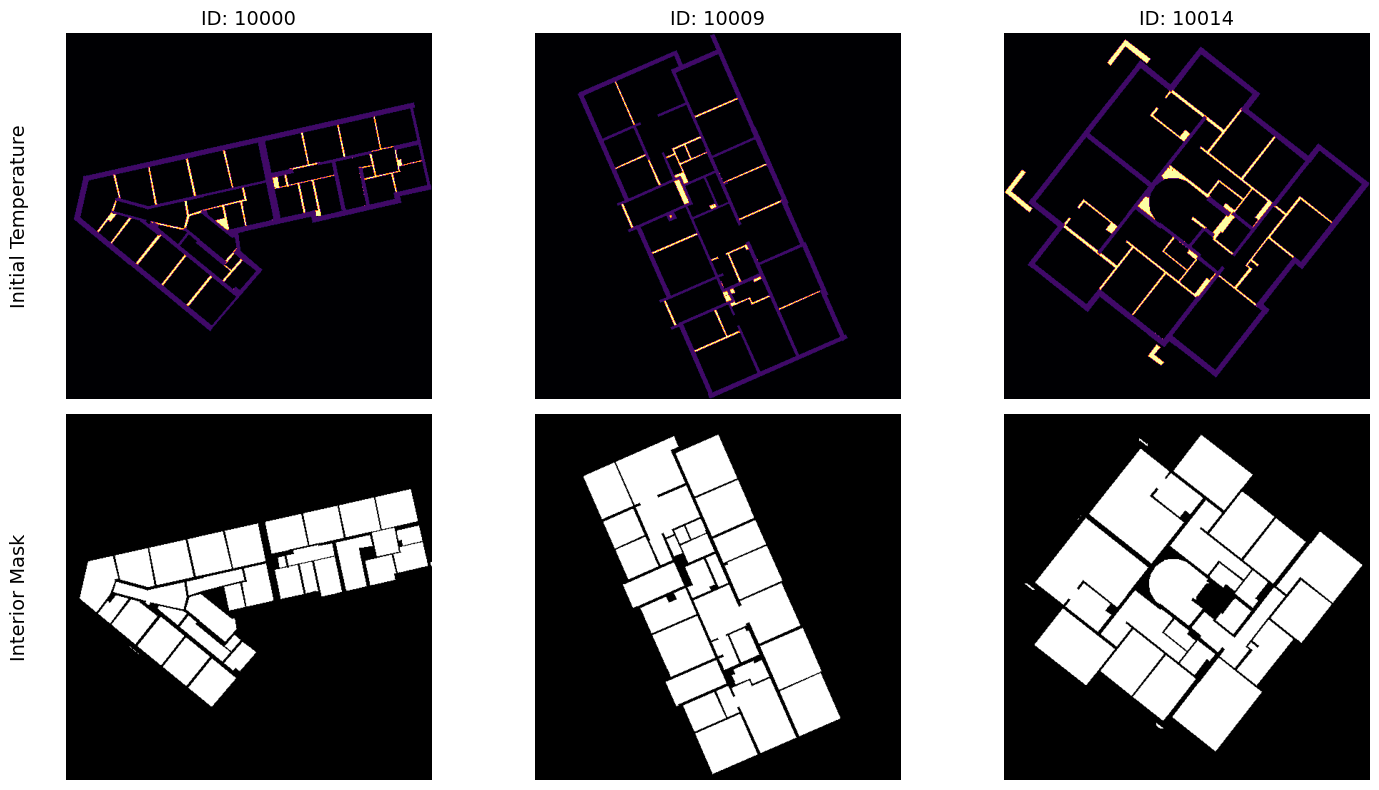

In [23]:
import matplotlib.pyplot as plt

def visualize_inputs_flipped_labeled(building_ids, all_u0, all_interior_mask):
    N = len(building_ids)
    fig, axs = plt.subplots(2, N, figsize=(5 * N, 8))

    if N == 1:
        axs = np.array([[axs[0]], [axs[1]]])  # Handle 1-column case

    row_labels = ['Initial Temperature', 'Interior Mask']

    for i in range(N):
        u0 = all_u0[i]
        mask = all_interior_mask[i]

        # Top row: u0
        axs[0, i].imshow(u0, cmap='inferno')
        axs[0, i].set_title(f'ID: {building_ids[i]}', fontsize=14)
        axs[0, i].axis('off')

        # Bottom row: interior mask
        axs[1, i].imshow(mask, cmap='gray')
        axs[1, i].axis('off')

    # Add row labels only on the first column (leftmost)
    for row_idx, label in enumerate(row_labels):
        axs[row_idx, 0].annotate(
            label, xy=(-0.1, 0.5), xycoords='axes fraction',
            ha='right', va='center', fontsize=14, #fontweight='bold',
            rotation=90
        )

    plt.tight_layout()
    plt.show()

# Call the visualization
visualize_inputs_flipped_labeled(building_ids, all_u0, all_interior_mask)
